<img src="Data/2.png" oncontextmenu="return false" style="margin-left:-5px;pointer-events:none;-webkit-touch-callout:none;" />

<font size=3><ul><li>Suganthan Thamotharampillai
<br><li>01.31.2023
<div style="border-style:solid;border-color:red;border-width:10px;border-width:0px;border-top-width:7px;">

<br><font size=5><b>Loading API Keys

In [1]:
import json
with open('/Users/sugan/.secret/yelp_api.json') as f:
    login = json.load(f)
login.keys()

dict_keys(['client-id', 'api-key'])

In [6]:
from yelpapi import YelpAPI
yelp_api = YelpAPI(login['api-key'], timeout_s=5.0)
yelp_api

In [50]:
help(yelp_api.search_query)

Help on method search_query in module yelpapi.yelpapi:

search_query(**kwargs) method of yelpapi.yelpapi.YelpAPI instance
    Query the Yelp Search API.
    
    documentation: https://www.yelp.com/developers/documentation/v3/business_search
    
    required parameters:
        * one of either:
            * location - text specifying a location to search for
            * latitude and longitude



<br><font size=5><b>API Call

In [7]:
# Quick Test Query
search_results = yelp_api.search_query(location='Baltimore, MD',
                                       term='Crab Cake')
print(type(results))
search_results.keys()

<class 'dict'>


dict_keys(['businesses', 'total', 'region'])

In [51]:
# use our yelp_api variable's search_query method to perform our API call
search_results = yelp_api.search_query(location='NY, NY',
                                       term='Pizza')
print(type(search_results))
search_results.keys()

<class 'dict'>


dict_keys(['businesses', 'total', 'region'])

In [52]:
search_results['total']

16700

In [53]:
biz = pd.DataFrame(search_results['businesses'])
biz.head(2) 

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,zj8Lq1T8KIC5zwFief15jg,prince-street-pizza-new-york-2,Prince Street Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/I4gm7i...,False,https://www.yelp.com/biz/prince-street-pizza-n...,4746,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",4.5,"{'latitude': 40.72308755605564, 'longitude': -...","[pickup, delivery]",$,"{'address1': '27 Prince St', 'address2': None,...",+12129664100,(212) 966-4100,2209.311618
1,ysqgdbSrezXgVwER2kQWKA,julianas-brooklyn-3,Juliana's,https://s3-media2.fl.yelpcdn.com/bphoto/NVoLFl...,False,https://www.yelp.com/biz/julianas-brooklyn-3?a...,2601,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.5,"{'latitude': 40.70274718768062, 'longitude': -...",[delivery],$$,"{'address1': '19 Old Fulton St', 'address2': '...",+17185966700,(718) 596-6700,1289.857286


<b>Pagination and "offset"

In [54]:
## how many businesses in our results
len(search_results['businesses'])

20

<b>"offset" is the # of results to be added to the display of the FIRST page[i think :)]

In [55]:
# add offset to our original api call
search_results = yelp_api.search_query(location='NY, NY',
                                       term='Pizza',
                                       offset = 20)

In [56]:
biz20 = pd.DataFrame(search_results['businesses'])
biz20.head(2)

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,TWH4MjLtN1fKlF-7n6YXHg,lil-frankies-new-york,Lil Frankie's,https://s3-media3.fl.yelpcdn.com/bphoto/t0OsEV...,False,https://www.yelp.com/biz/lil-frankies-new-york...,1419,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",4.0,"{'latitude': 40.723625, 'longitude': -73.988555}","[delivery, pickup]",$$,"{'address1': '19 1st Ave', 'address2': '', 'ad...",+12124204900,(212) 420-4900,2006.256439
1,i_rg-OLXQbpRUN7O3MeCeA,piz-zetta-brooklyn-2,Piz-zetta,https://s3-media4.fl.yelpcdn.com/bphoto/T-xxG2...,False,https://www.yelp.com/biz/piz-zetta-brooklyn-2?...,332,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",4.5,"{'latitude': 40.69116658201196, 'longitude': -...","[delivery, pickup]",$,"{'address1': '90 Livingston St', 'address2': '...",+17184227878,(718) 422-7878,2006.561238


<Br><b>CONCATENATE FIRST AND SECOND TABLES, WHERE BOTH HAVE DIFFERENT RESULTS, AND SEE HOW IT LOOKS

In [57]:
## concatenate the previous results and new results. 
businesses = pd.concat([biz, biz20],
                      ignore_index=True)
display(businesses.head(3), businesses.tail(3))

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,zj8Lq1T8KIC5zwFief15jg,prince-street-pizza-new-york-2,Prince Street Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/I4gm7i...,False,https://www.yelp.com/biz/prince-street-pizza-n...,4746,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",4.5,"{'latitude': 40.72308755605564, 'longitude': -...","[pickup, delivery]",$,"{'address1': '27 Prince St', 'address2': None,...",+12129664100,(212) 966-4100,2209.311618
1,ysqgdbSrezXgVwER2kQWKA,julianas-brooklyn-3,Juliana's,https://s3-media2.fl.yelpcdn.com/bphoto/NVoLFl...,False,https://www.yelp.com/biz/julianas-brooklyn-3?a...,2601,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.5,"{'latitude': 40.70274718768062, 'longitude': -...",[delivery],$$,"{'address1': '19 Old Fulton St', 'address2': '...",+17185966700,(718) 596-6700,1289.857286
2,WG639VkTjmK5dzydd1BBJA,rubirosa-new-york-2,Rubirosa,https://s3-media4.fl.yelpcdn.com/bphoto/LuSzR8...,False,https://www.yelp.com/biz/rubirosa-new-york-2?a...,2903,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",4.5,"{'latitude': 40.722766, 'longitude': -73.996233}",[pickup],$$,"{'address1': '235 Mulberry St', 'address2': ''...",+12129650500,(212) 965-0500,2268.491950


,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
37,UB1mGugr1pvgUUP1eTNXrg,stone-bridge-pizza-and-salad-new-york,Stone Bridge Pizza & Salad,https://s3-media1.fl.yelpcdn.com/bphoto/yfY3OA...,False,https://www.yelp.com/biz/stone-bridge-pizza-an...,318,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",4.5,"{'latitude': 40.75225, 'longitude': -73.98061}","[delivery, pickup]",$$,"{'address1': '16 E 41st St', 'address2': None,...",+16467915690,(646) 791-5690,5039.358201
38,G77Q6kU-7qRefColCRTS0w,robertas-brooklyn-5,Roberta's,https://s3-media2.fl.yelpcdn.com/bphoto/JFWxMy...,False,https://www.yelp.com/biz/robertas-brooklyn-5?a...,79,"[{'alias': 'pizza', 'title': 'Pizza'}]",3.5,"{'latitude': 40.71618788546057, 'longitude': -...","[delivery, pickup]",NaN,"{'address1': '6 Grand St', 'address2': '', 'ad...",+17182782400,(718) 278-2400,1479.577607
39,-CCfu19Uuy_kD2t4ZwsQfA,village-square-pizza-new-york-3,Village Square Pizza,https://s3-media1.fl.yelpcdn.com/bphoto/3gFPiI...,False,https://www.yelp.com/biz/village-square-pizza-...,261,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.5,"{'latitude': 40.72748, 'longitude': -73.98268}","[delivery, pickup]",$,"{'address1': '147 Ave A', 'address2': None, 'a...",+19176757709,(917) 675-7709,2303.721319


<br><font size=5><b>Traversing JSON with Python<br><font size=4>PANDAS Dataframe

In [20]:
## We will explore the following .json file that is an example of the output from a yelp api call searching for crab cakes in Baltimore
## The is an Example Yelp Results file

## What is the top-level of the JSON data?
# Open the jsonfile and display the first level of keys
# open API results WITH json module
import json
with open('Data/example_yelp_results.json') as f:   #adjust for your path
    json_file = json.load(f)
    
## What type is top-level of json?
type(json_file)

dict

In [21]:
# what are the keys?
json_file.keys()

dict_keys(['businesses', 'total', 'region'])

<b>'region'

In [22]:
## now we will explore region
## What is stored in the second-level?
#We have three keys to explore.  We will start by exploring region.
# what type is region?
type(json_file['region'])

dict

In [23]:
# what keys are in region?
json_file['region'].keys()

dict_keys(['center'])

In [24]:
# what type is center?
type(json_file['region']['center'])

dict

In [25]:
# what are the keys in center?
json_file['region']['center'].keys()

dict_keys(['longitude', 'latitude'])

In [28]:
json_file['region']['center']['longitude']

-76.607666015625

In [29]:
json_file['region']['center']['latitude']

39.29617825404647

In [30]:
# My View
json_file['region']

{'center': {'longitude': -76.607666015625, 'latitude': 39.29617825404647}}

In [31]:
# Visualize the whole center dict, since lat and long are likely single values
json_file['region']['center']

{'longitude': -76.607666015625, 'latitude': 39.29617825404647}

In [ ]:
##It looks like we have the coordinates for the center of the region that Yelp searched through.

<b>'total'

In [32]:
## Now we will explore "total"
# what is stored under the "total" key?
type(json_file['total'])

int

In [37]:
## what is the value?
json_file['total']

435

<b>Mistakes List

In [43]:
json_file['total'].keys()

AttributeError: 'int' object has no attribute 'keys'

In [42]:
json_file['total'][0]

TypeError: 'int' object is not subscriptable

<b>'businesses'

In [38]:
## And finally, we will explore "businesses"
# what is in the businesses key?
type(json_file['businesses'])

list

In [40]:
# how long is businesses?
len(json_file['businesses']) # It looks like there are 20 businesses stored in the list

20

In [41]:
# what does the first entry of business look like?
json_file['businesses'][0]

{'id': 'D9A33FM394q99o4QtK5YwA',
 'alias': 'faidleys-seafood-baltimore-3',
 'name': 'Faidleys Seafood',
 'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/OTjVDCVS7pGopH6GZcfjBA/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.com/biz/faidleys-seafood-baltimore-3?adjust_creative=KJtcufKUS887p24u6rjVIQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=KJtcufKUS887p24u6rjVIQ',
 'review_count': 1184,
 'categories': [{'alias': 'seafood', 'title': 'Seafood'},
  {'alias': 'beerbar', 'title': 'Beer Bar'}],
 'rating': 4.0,
 'coordinates': {'latitude': 39.291696, 'longitude': -76.62224},
 'transactions': ['delivery'],
 'price': '$$',
 'location': {'address1': '203 N Paca St',
  'address2': '',
  'address3': '',
  'city': 'Baltimore',
  'zip_code': '21201',
  'country': 'US',
  'state': 'MD',
  'display_address': ['203 N Paca St', 'Baltimore, MD 21201']},
 'phone': '+14107274898',
 'display_phone': '(410) 727-4898',
 'distance': 1349.560720156645}

In [44]:
## Its a dictionary. What are the keys?
## what are the keys of the first entry in businesses?
json_file['businesses'][0].keys()

dict_keys(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count', 'categories', 'rating', 'coordinates', 'transactions', 'price', 'location', 'phone', 'display_phone', 'distance'])

In [45]:
## what are the keys of the NEXT entry in businesses? Do they math the first?
json_file['businesses'][1].keys()

dict_keys(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count', 'categories', 'rating', 'coordinates', 'transactions', 'price', 'location', 'phone', 'display_phone', 'distance'])

In [47]:
## So that means its going to be the same for all 20 'RECORDS'
## what are the keys of the NEXT entry in businesses? Do they math the first?
json_file['businesses'][19].keys()

dict_keys(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count', 'categories', 'rating', 'coordinates', 'transactions', 'price', 'location', 'phone', 'display_phone', 'distance'])

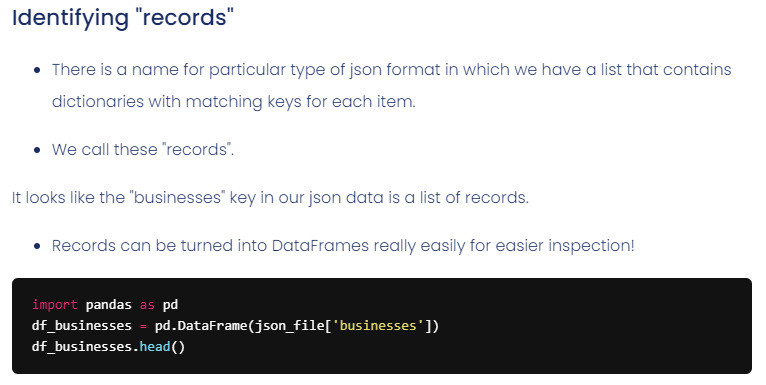

<b><font size=5>PANDAS</FONT><BR>Records can be turned into DataFrames really easily for easier inspection!
    

In [48]:
import pandas as pd
df_businesses = pd.DataFrame(json_file['businesses'])
df_businesses.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,D9A33FM394q99o4QtK5YwA,faidleys-seafood-baltimore-3,Faidleys Seafood,https://s3-media3.fl.yelpcdn.com/bphoto/OTjVDC...,False,https://www.yelp.com/biz/faidleys-seafood-balt...,1184,"[{'alias': 'seafood', 'title': 'Seafood'}, {'a...",4.0,"{'latitude': 39.291696, 'longitude': -76.62224}",[delivery],$$,"{'address1': '203 N Paca St', 'address2': '', ...",+14107274898,(410) 727-4898,1349.560720
1,u65W69AhbjUlvJJBkEhGNQ,miss-shirleys-cafe-baltimore-9,Miss Shirley's Cafe,https://s3-media4.fl.yelpcdn.com/bphoto/9FsOyV...,False,https://www.yelp.com/biz/miss-shirleys-cafe-ba...,2919,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.0,"{'latitude': 39.2870995, 'longitude': -76.6053...","[delivery, pickup]",$$,"{'address1': '750 E Pratt St', 'address2': '',...",+14105285373,(410) 528-5373,1028.736468
2,ieS_5zqxDHcWMCm8BKUYbg,thames-street-oyster-house-baltimore,Thames Street Oyster House,https://s3-media1.fl.yelpcdn.com/bphoto/9hGjo5...,False,https://www.yelp.com/biz/thames-street-oyster-...,2729,"[{'alias': 'seafood', 'title': 'Seafood'}, {'a...",4.5,"{'latitude': 39.28214, 'longitude': -76.59162}",[delivery],$$$,"{'address1': '1728 Thames St', 'address2': '',...",+14434497726,(443) 449-7726,2090.712792
3,6am8TZAFnvND52MOz-Yctg,mamas-on-the-half-shell-baltimore,Mama's On The Half Shell,https://s3-media2.fl.yelpcdn.com/bphoto/HWY8OF...,False,https://www.yelp.com/biz/mamas-on-the-half-she...,1279,"[{'alias': 'bars', 'title': 'Bars'}, {'alias':...",4.0,"{'latitude': 39.27986, 'longitude': -76.5752399}","[delivery, pickup]",$$,"{'address1': '2901 Odonnell St', 'address2': '...",+14102763160,(410) 276-3160,3328.825798
4,ISn7WyGQaFpsVSRSh0NSqg,sal-and-sons-baltimore,Sal and Sons,https://s3-media3.fl.yelpcdn.com/bphoto/LmVL4j...,False,https://www.yelp.com/biz/sal-and-sons-baltimor...,153,"[{'alias': 'seafood', 'title': 'Seafood'}, {'a...",4.5,"{'latitude': 39.284, 'longitude': -76.59337}",[delivery],$,"{'address1': '1640 Aliceanna St', 'address2': ...",+14106751466,(410) 675-1466,1817.406978


<br><b><font size=3 color=red>There are still some Imperfections

In [49]:
df_businesses[['categories','coordinates','location']].head(3)

,categories,coordinates,location
0,"[{'alias': 'seafood', 'title': 'Seafood'}, {'a...","{'latitude': 39.291696, 'longitude': -76.62224}","{'address1': '203 N Paca St', 'address2': '', ..."
1,"[{'alias': 'breakfast_brunch', 'title': 'Break...","{'latitude': 39.2870995, 'longitude': -76.6053...","{'address1': '750 E Pratt St', 'address2': '',..."
2,"[{'alias': 'seafood', 'title': 'Seafood'}, {'a...","{'latitude': 39.28214, 'longitude': -76.59162}","{'address1': '1728 Thames St', 'address2': '',..."


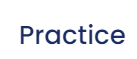
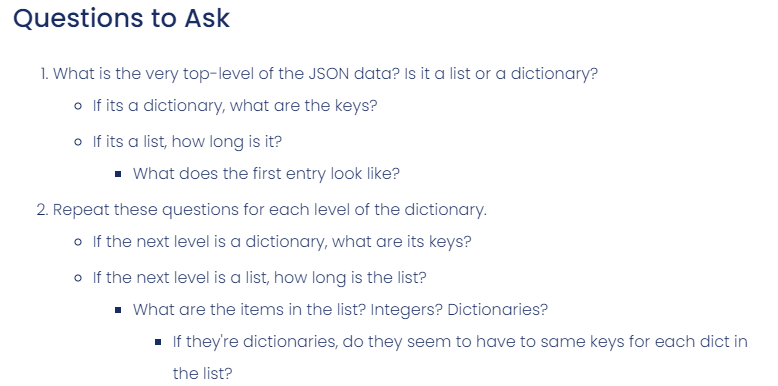

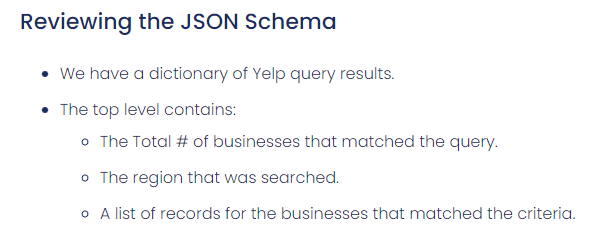

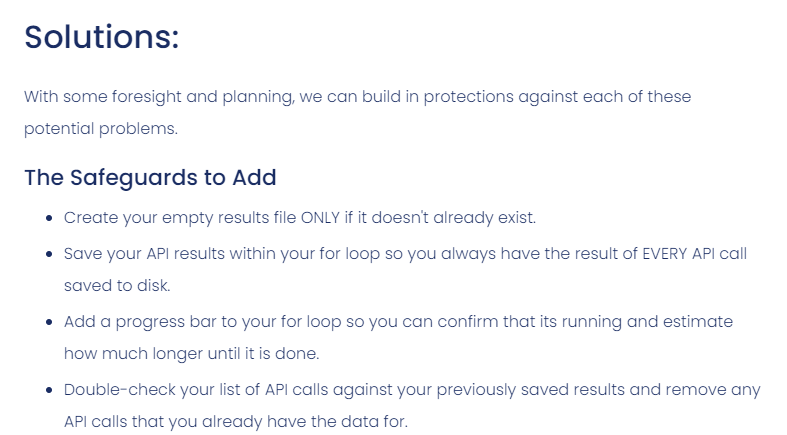

<br><b><font size=5>Adding Safeguards to our Data Extraction Workflow

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Imports
import os, json, math, time
from yelpapi import YelpAPI
from tqdm.notebook import tqdm_notebook

<b>Credentials and Accessing the API

In [2]:
# Load API Credentials
with open('/Users/sugan/.secret/yelp_api.json') as f:
    login = json.load(f)
    
# Instantiate YelpAPI Variable
yelp_api = YelpAPI(login['api-key'], timeout_s=5.0)

<b>Define Search<br>
This streamlines the code and makes it more readable and reproducible

In [15]:
# Set API call parameters 
LOCATION = 'NY,NY'
TERM = 'Pizza'

<b>Create a results-in-progress JSON file, but only if it doesn't exist

In [4]:
# Specifying JSON_FILE filename (can include a folder)
# include the search terms in the filename
JSON_FILE = "Data/ApiResults/results_in_progress_NY_pizza.json"
JSON_FILE

'Data/ApiResults/results_in_progress_NY_pizza.json'

In [13]:
## Check if JSON_FILE exists
file_exists = os.path.isfile(JSON_FILE)
## If it does not exist: 
if file_exists == False:
    
    ## CREATE ANY NEEDED FOLDERS
    # Get the Folder Name only
    folder = os.path.dirname(JSON_FILE)
    ## If JSON_FILE included a folder:
    if len(folder)>0:
        # create the folder
        os.makedirs(folder,exist_ok=True)
        
        
    ## INFORM USER AND SAVE EMPTY LIST
    print(f'[i] {JSON_FILE} not found. Saving empty list to file.')
    
    
    # save an empty list
#     with open(JSON_FILE,'w') as f:
#         json.dump([],f)
#     file_exists = os.path.isfile(JSON_FILE)
#     if file_exists == True:
#         print(f'[i] {JSON_FILE} created.')

    ## OR
    
    with open(JSON_FILE,'w') as f:
        json.dump([],f)
    if os.path.isfile(JSON_FILE) == True:
        print(f'[i] {JSON_FILE} created.')
# If it exists, inform user
else:
    print(f"[i] {JSON_FILE} already exists.")

[i] Data/ApiResults/results_in_progress_NY_pizza.json not found. Saving empty list to file.
[i] Data/ApiResults/results_in_progress_NY_pizza.json created.


<b>Determine how many results are already in the file

In [14]:
## Load previous results and use len of results for offset
with open(JSON_FILE,'r') as f:
    previous_results = json.load(f)
    
## set offset based on previous results
n_results = len(previous_results)
print(f'- {n_results} previous results found.')

- 0 previous results found.


<b>Figure out how many pages of results we will need

In [16]:
# use our yelp_api variable's search_query method to perform our API call
results = yelp_api.search_query(location=LOCATION,
                                term=TERM,
                               offset=n_results)
results.keys()

dict_keys(['businesses', 'total', 'region'])

In [17]:
## How many results total?
total_results = results['total']
total_results

16200

In [18]:
## How many did we get the details for?
results_per_page = len(results['businesses'])
results_per_page

20

In [19]:
# Import additional packages for controlling our loop
import time, math
# Use math.ceil to round up for the total number of pages of results.
n_pages = math.ceil((results['total']-n_results)/ results_per_page) #ceil seals the integer rounding it upward
n_pages

810

<b>Add this page of results to .json file

In [ ]:
# join new results with old list with extend and save to file
previous_results.extend(results['businesses'])  
with open(JSON_FILE,'w') as f:
     json.dump(previous_results,f)

<b>Set up a progress bar in our for loop</b><br>
    To keep us informed about where we are in our loop, we will add a progress bar to our for loop

In [ ]:
from tqdm.notebook import tqdm_notebook
import time
for i in tqdm_notebook(range(n_pages)):
    # adds 200 ms pause
    time.sleep(.2) 

<img src="Data/tqdm_notebook.png" width=50% align=left>

<b>For Loop to call each page

In [ ]:
for i in tqdm_notebook( range(1,n_pages+1)):
    
    ## Read in results in progress file and check the length
    with open(JSON_FILE, 'r') as f:
        previous_results = json.load(f)
    ## save number of results for to use as offset
    n_results = len(previous_results)
    ## use n_results as the OFFSET 
    results = yelp_api.search_query(location=LOCATION,
                                    term=TERM, 
                                    offset=n_results)
    
    ## append new results and save to file
    previous_results.extend(results['businesses'])
    
    with open(JSON_FILE,'w') as f:
        json.dump(previous_results,f)
    
    # add a 200ms pause
    time.sleep(.2)

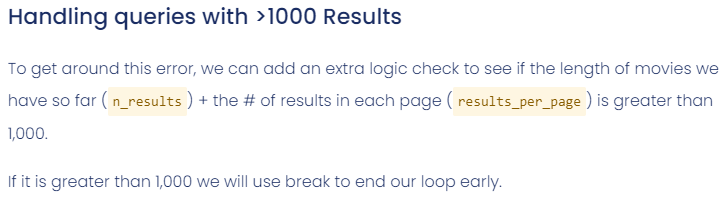

<font size=4>New and Improved Loop</font><br> 
<b>Deleting Our Previous Results FIle

In [27]:
# Let's give ourselves a fresh start with our new and improved loop
# Let's delete our previous results file.

## delete file and confirm it no longer exits.
os.remove(JSON_FILE)
os.path.isfile(JSON_FILE)

False

In [29]:
## CREATE FUNCTION
def create_json_file(JSON_FILE,  delete_if_exists=False):
    
    ## Check if JSON_FILE exists
    file_exists = os.path.isfile(JSON_FILE)
    
    ## If it DOES exist:
    if file_exists == True:
        
        ## Check if user wants to delete if exists
        if delete_if_exists==True:
            
            print(f"[!] {JSON_FILE} already exists. Deleting previous file...")
            ## delete file and confirm it no longer exits.
            os.remove(JSON_FILE)
            ## Recursive call to function after old file deleted
            create_json_file(JSON_FILE,delete_if_exists=False)
        else:
            print(f"[i] {JSON_FILE} already exists.")            
            
            
    ## If it does NOT exist:
    else:
        
        ## INFORM USER AND SAVE EMPTY LIST
        print(f"[i] {JSON_FILE} not found. Saving empty list to new file.")
        
        ## CREATE ANY NEEDED FOLDERS
        # Get the Folder Name only
        folder = os.path.dirname(JSON_FILE)
        
        ## If JSON_FILE included a folder:
        if len(folder)>0:
            # create the folder
            os.makedirs(folder,exist_ok=True)
        ## Save empty list to start the json file
        with open(JSON_FILE,'w') as f:
            json.dump([],f)
        if os.path.isfile(JSON_FILE) == True:
            print(f'[i] {JSON_FILE} created.')

In [30]:
# TESTING FUNCTION
create_json_file(JSON_FILE,  delete_if_exists=False)

[i] Data/ApiResults/results_in_progress_NY_pizza.json not found. Saving empty list to new file.
[i] Data/ApiResults/results_in_progress_NY_pizza.json created.


In [ ]:
## Create a new empty json file (exist the previous if it exists)
create_json_file(JSON_FILE, delete_if_exists=True)
## Load previous results and use len of results for offset
with open(JSON_FILE,'r') as f:
    previous_results = json.load(f)
    
## set offset based on previous results
n_results = len(previous_results)
print(f'- {n_results} previous results found.')
# use our yelp_api variable's search_query method to perform our API call
results = yelp_api.search_query(location=LOCATION,
                                term=TERM,
                               offset=n_results)
## How many results total?
total_results = results['total']
## How many did we get the details for?
results_per_page = len(results['businesses'])
# Use math.ceil to round up for the total number of pages of results.
n_pages = math.ceil((results['total']-n_results)/ results_per_page)
n_pages

In [31]:
## NEXT STAGE
## Create a new empty json file (exist the previous if it exists)
create_json_file(JSON_FILE, delete_if_exists=True)
## Load previous results and use len of results for offset
with open(JSON_FILE,'r') as f:
    previous_results = json.load(f)
    
## set offset based on previous results
n_results = len(previous_results)
print(f'- {n_results} previous results found.')
# use our yelp_api variable's search_query method to perform our API call
results = yelp_api.search_query(location=LOCATION,
                                term=TERM,
                               offset=n_results)
## How many results total?
total_results = results['total']
## How many did we get the details for?
results_per_page = len(results['businesses'])
# Use math.ceil to round up for the total number of pages of results.
n_pages = math.ceil((results['total']-n_results)/ results_per_page)
n_pages

[!] Data/ApiResults/results_in_progress_NY_pizza.json already exists. Deleting previous file...
[i] Data/ApiResults/results_in_progress_NY_pizza.json not found. Saving empty list to new file.
[i] Data/ApiResults/results_in_progress_NY_pizza.json created.
- 0 previous results found.


795

<b>Loop

In [ ]:
for i in tqdm_notebook( range(1,n_pages+1)):
    
    ## Read in results in progress file and check the length
    with open(JSON_FILE, 'r') as f:
        previous_results = json.load(f)
    ## save number of results for to use as offset
    n_results = len(previous_results)
    
    if (n_results + results_per_page) > 1000:
        print('Exceeded 1000 api calls. Stopping loop.')
        break
    
    ## use n_results as the OFFSET 
    results = yelp_api.search_query(location=LOCATION,
                                    term=TERM, 
                                    offset=n_results)
    
    
    
    ## append new results and save to file
    previous_results.extend(results['businesses'])
    
    # display(previous_results)
    with open(JSON_FILE,'w') as f:
        json.dump(previous_results,f)
    
    time.sleep(.2)

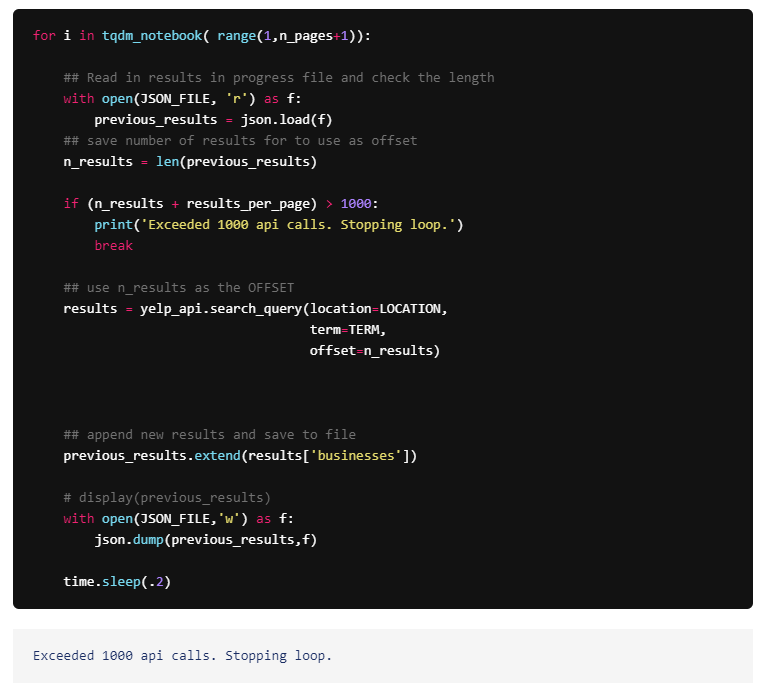

<font size=4>After the loop has finished</font><br> 
<font size=5>PANDAS Convert .json to dataframe</font><br> 
Convert .json to dataframe
Load in the "results in progress" JSON file into a DataFrame:

In [32]:
# load final results
final_df = pd.read_json(JSON_FILE)
display(final_df.head(), final_df.tail())

""


""


<b>Check for duplicates

In [33]:
# Check for and remove any duplicate results.
# check for duplicate results
final_df.duplicated().sum()

0

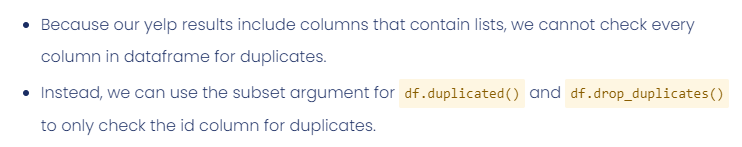

In [34]:
# check for duplicate ID's 
final_df.duplicated(subset='id').sum()

0

In [35]:
## Drop duplicate ids and confirm there are no more duplicates
final_df = final_df.drop_duplicates(subset='id')
final_df.duplicated(subset='id').sum()

0

<b>Final Save

In [ ]:
# save the final results to a compressed csv
final_df.to_csv('Data/final_results_NY_pizza.csv.gz', compression='gzip',index=False)

In [ ]:
- THE END -

<br><b><font size=5>Advanced Transformations with Pandas

<img style=display:inline; src=Data/yelp-logo.png width=10% /><br><font size=5><b>Yelp API Package</b></font>

 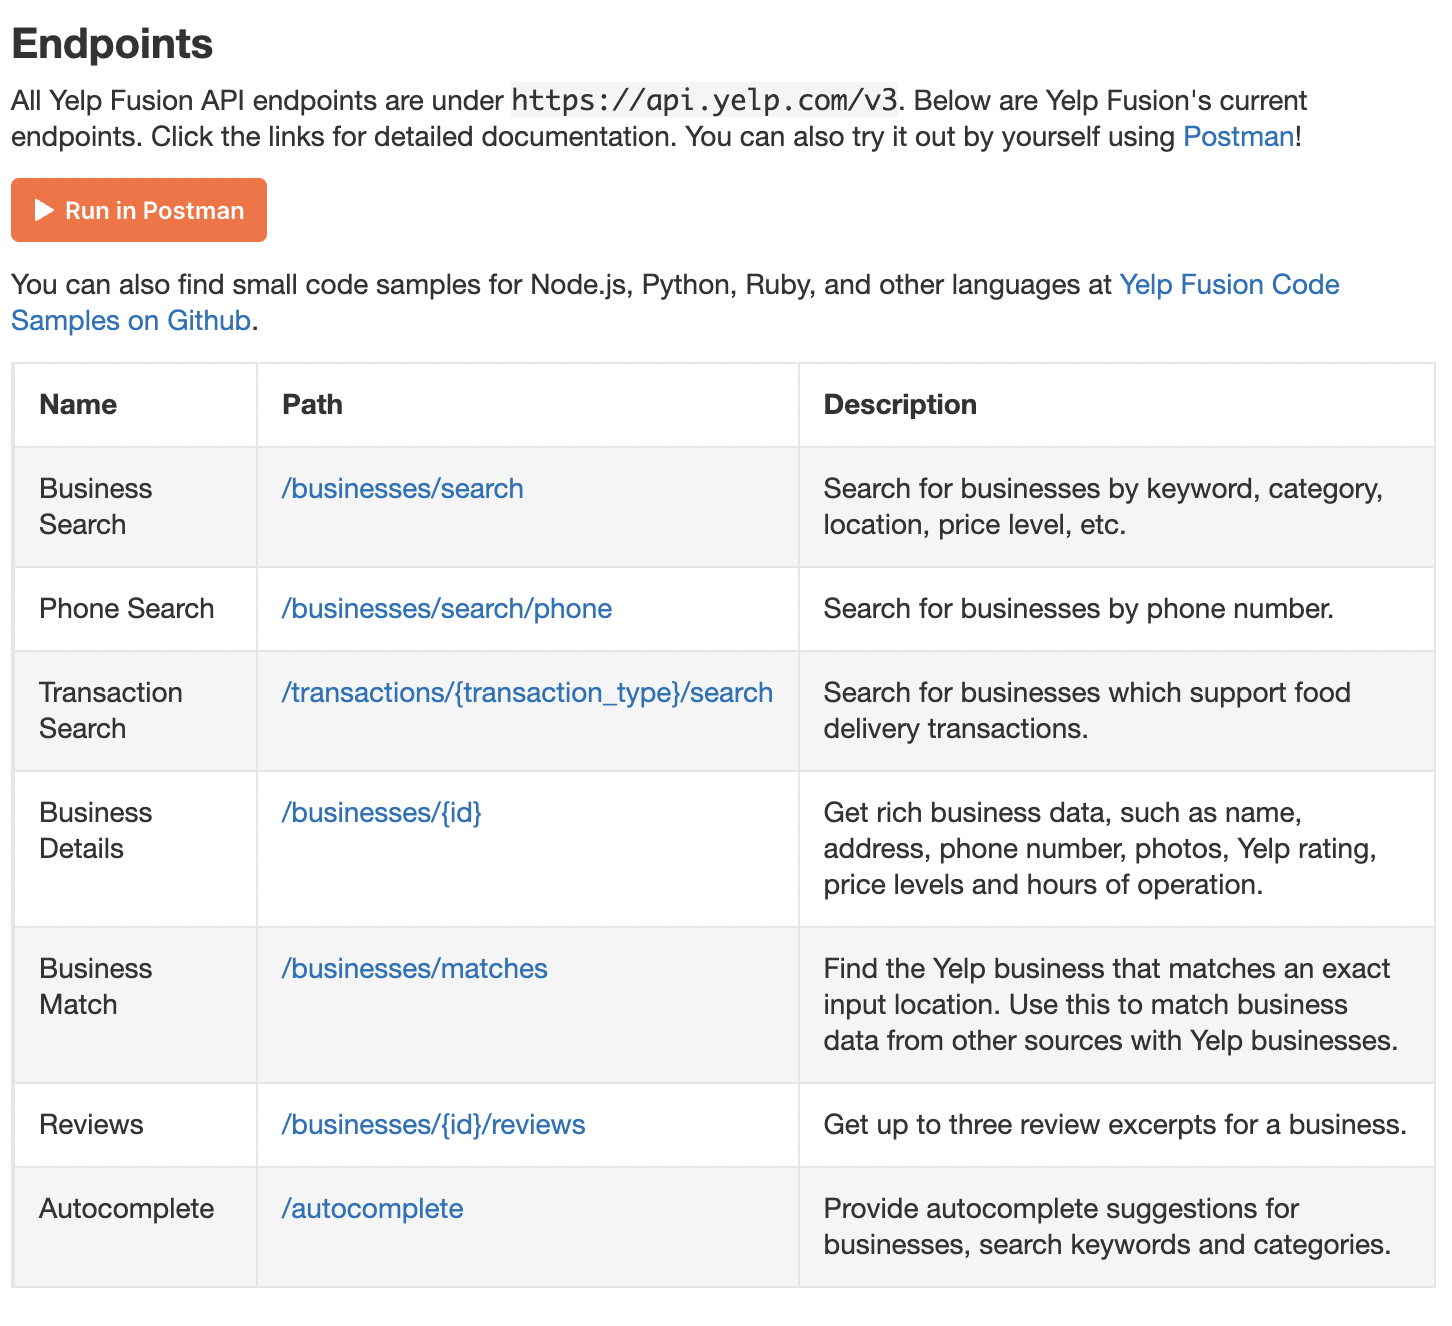

<B>IT HAS ALL THE INBUILT QUERIES

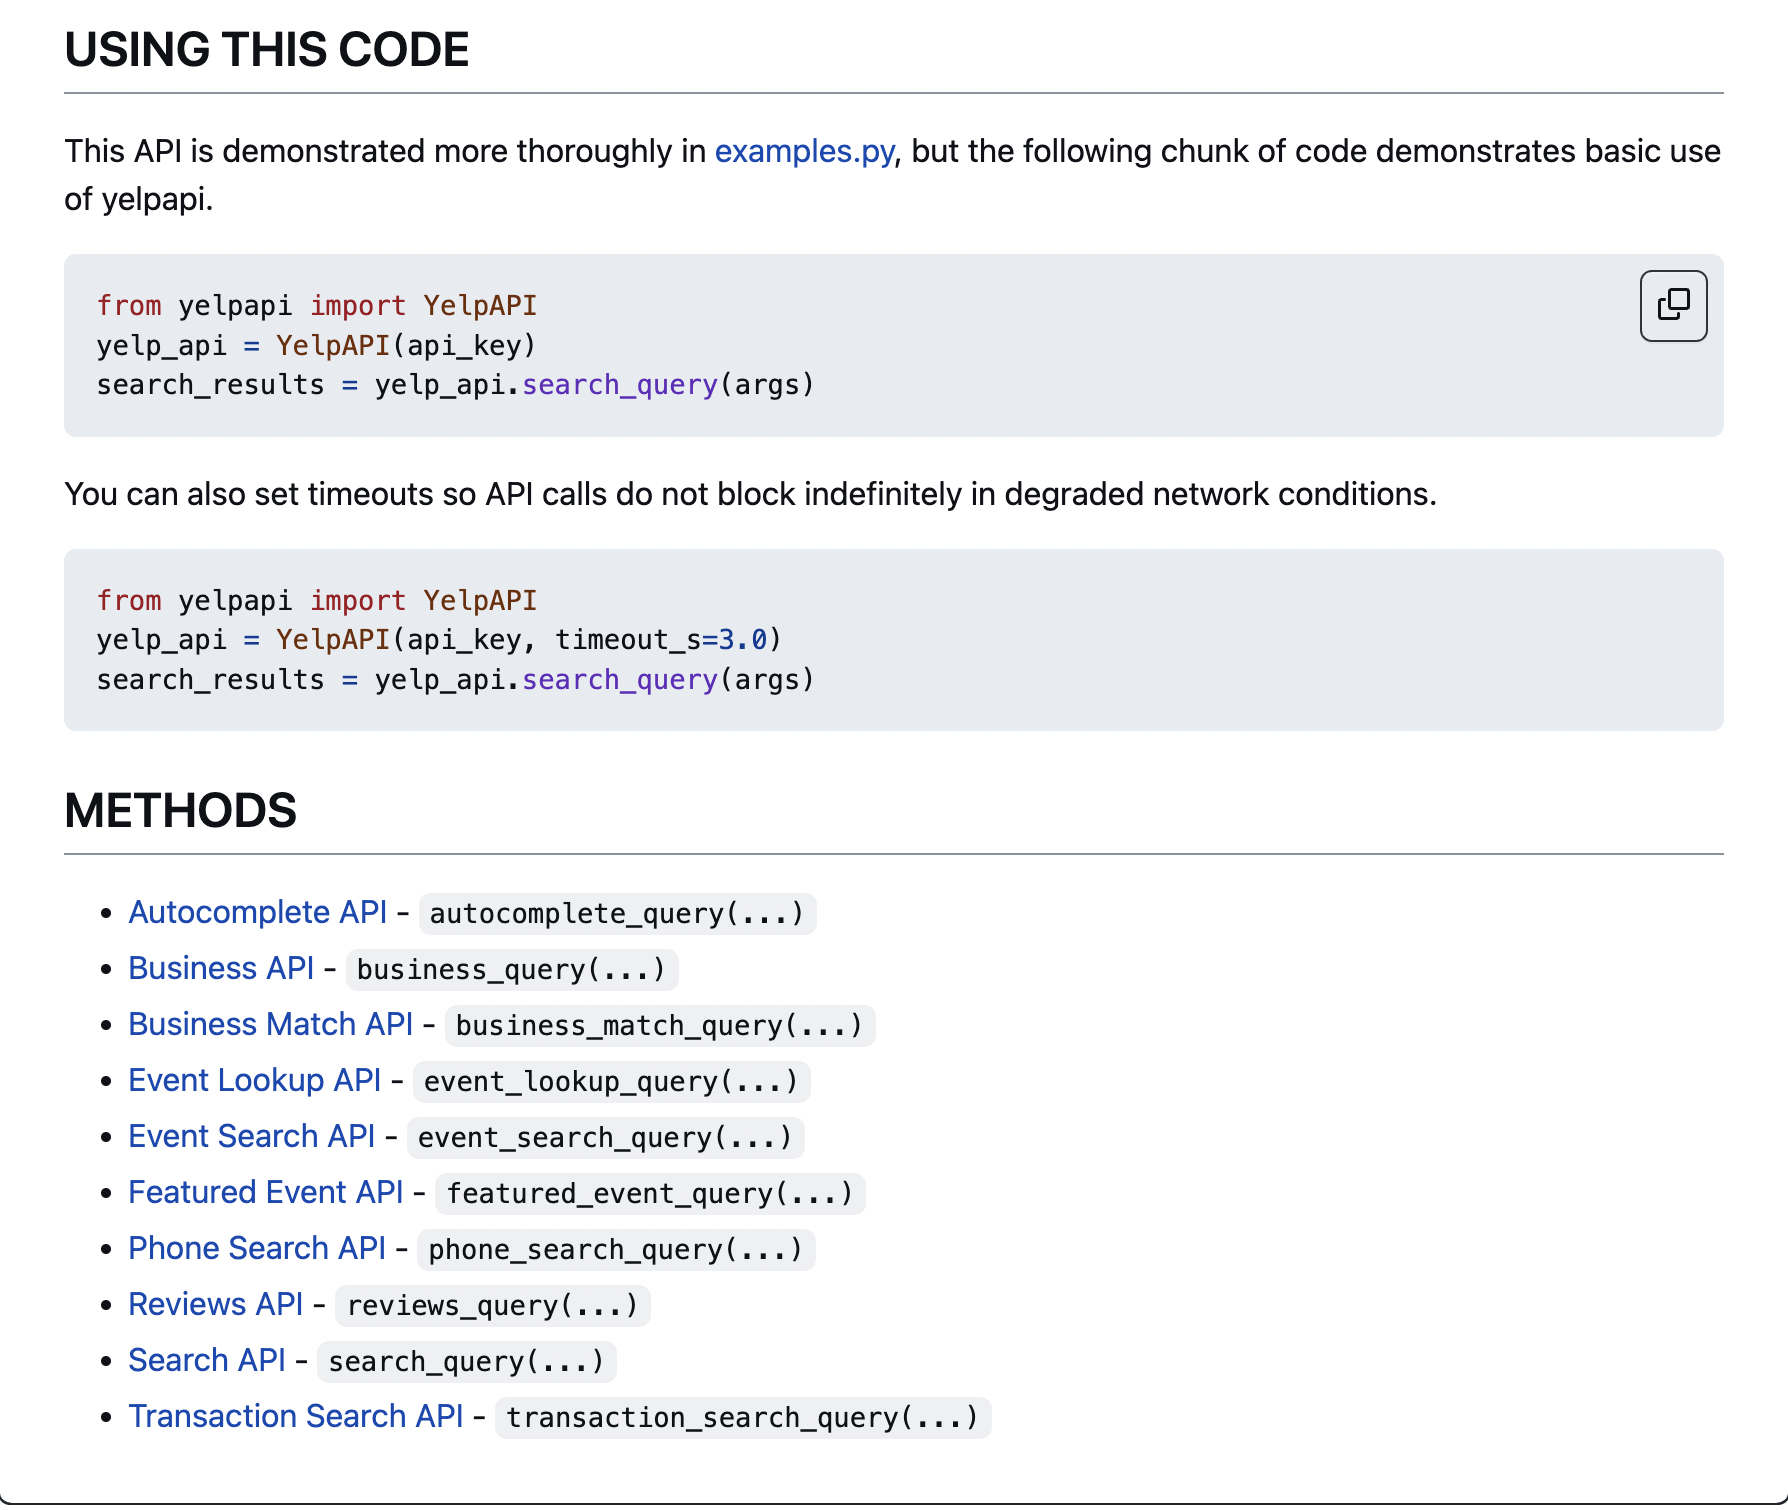

<br><font size=5><b>Saving and Loading Files Using json load and dump

In [13]:
import json
## Saving a dictionary to a JSON file
# Using single quotes here, the jason module is smartenough to conver to doulbe quotes
data = {'stack':4, 'week':2, 
       'things learned':['MySQL','MySQL WorkBench',
                         'GitHub Desktop','Jupyter Notebooks','JSON' ]}
data

{'stack': 4,
 'week': 2,
 'things learned': ['MySQL',
  'MySQL WorkBench',
  'GitHub Desktop',
  'Jupyter Notebooks',
  'JSON']}

In [14]:
## Saving to file: using "with open" to write to file ('w') and json.dump
# save dict to json file with json.dump
with open('Data/example_saved_data.json','w') as f:
    json.dump(data, f)

In [15]:
## Opening a file: using "with open" to read a file ('r') and json.load
# Load saved json file back to dictionary
with open('Data/example_saved_data.json') as f:
    loaded = json.load(f)
loaded

{'stack': 4,
 'week': 2,
 'things learned': ['MySQL',
  'MySQL WorkBench',
  'GitHub Desktop',
  'Jupyter Notebooks',
  'JSON']}

In [16]:
## Check on your file
print(type(loaded))
loaded.keys()

<class 'dict'>


dict_keys(['stack', 'week', 'things learned'])

In [17]:
## DO NOT DISPLAY THE VALUES OF YOUR DICTIONARIES!!!
loaded.values()

dict_values([4, 2, ['MySQL', 'MySQL WorkBench', 'GitHub Desktop', 'Jupyter Notebooks', 'JSON']])

<br><font size=5><b>Reading and Writing Files in Python

In [8]:
# This is the example message we want to save as .txt
message = """My test message to save to file.
It is a multi-line string."""
message

'My test message to save to file.\nIt is a multi-line string.'

In [12]:
# Saving to file: using "with open" to write to file ('w')
# Save it to a file
with open('Data/my_first_savefile.txt','w') as file:
    file.write(message)
with open('C:/Users/sugan/Documents/my_first_savefile.txt','w') as file:
    file.write(message)
    
# Read from file
with open('Data/my_first_savefile.txt','r') as f:
    loaded = f.read()
loaded
with open('C:/Users/sugan/Documents/my_first_savefile.txt','r') as f:
    loaded = f.read()
loaded

'My test message to save to file.\nIt is a multi-line string.'